# Implémentez un modèle de scoring
## Analyse exploratoire et feature ingineering  
OpenClassrooms - Parcours Data Scientist - Projet 07  

# 1. Introduction

La société financière __Prêt à dépenser__ propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
Cette activité repose sur la capacité à prédire si un client pourra ou aura des difficultés à rembourser un prêt.  

En 2018 __Prêt à dépenser__ organise une [compétition Kaggle](https://www.kaggle.com/c/home-credit-default-risk).  
L'objectif de cette compétition était de trouver les meilleurs modèles de machine learning pouvant réaliser ces prédictions.  

L'analyse exploratoire et le feature ingineering qui suivent sont largement inspirés de deux kernels Kaggle liés à cette compétition :  
> [Start Here: A Gentle Introduction](https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook) de Will Koehrsen pour la partie exploratoire  
> [LightGBM with Simple Features](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script) d'Aguiar pour la préparation des données et le feature ingineering

## 1.1. Présentation des données

Les sources de données sont fournies sous forme de fichiers csv :

* __application_train/application_test__ : données d'entraînement et de test contenant les principales informations sur chaque demande de prêt chez Home Credit. Chaque prêt possède sa propre ligne et est identifié par la feature `SK_ID_CURR`. Les données d'entraînement sont accompagnées de la feature `TARGET` :
    * 0 : le prêt a été remboursé  
    * 1 : le prêt n'a pas été remboursé  
* __bureau__ : données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit antérieur possède une ligne unique dans la table bureau, mais un même client peut avoir plusieurs crédits précédents.
* __bureau_balance__ : données mensuelles sur les crédits antérieurs dans le ficheir bureau. Chaque ligne représente un mois d'un crédit antérieur, et un seul crédit antérieur peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.
* __previous_application__ : demandes précédentes de prêts chez Home Credit des clients qui ont des prêts dans la table application (données d'entraînement ou de test). Chaque prêt en cours dans la table application peut avoir plusieurs prêts précédents. Chaque demande précédente comporte une ligne et est identifiée par la feature `SK_ID_PREV`.
* __POS_CASH_BALANCE__ : données mensuelles sur les précédents points de vente ou prêts de trésorerie que les clients ont contractés avec Home Credit. Chaque ligne correspond à un mois d'un point de vente ou d'un prêt de trésorerie précédent, et un seul prêt précédent peut comporter plusieurs lignes.
* __credit_card_balance__ : données mensuelles sur les cartes de crédit précédentes que les clients ont eues avec Home Credit. Chaque ligne représente un mois du solde d’une carte de crédit, et une seule carte de crédit peut comporter plusieurs lignes.
* __installments_payment__ : historique de paiement des prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.

Schéma relationnel :

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

La définition des variables est fournie dans le fichier `HomeCredit_columns_description.csv`.  
Le jeu de données est complété par un exemple de fichier de soumission pour la compétition : `sample_submission.csv`. 

## 1.2. Environnement virtuel

In [1]:
# Vérification environnement virtuel
envs = !conda env list
print(f"Environnement virtuel : {[e for e in envs if '*' in e][0].split('*')[1].strip()}")

Environnement virtuel : C:\Users\chrab\anaconda3\envs\opc07_1


## 1.3. Imports

In [2]:
import sys
import subprocess
import pkg_resources

def install_package(package):
    """Installe une librairie en mode silencieux si elle n'est pas encore installée et affiche sa version."""
    try:
        dist = pkg_resources.get_distribution(package)
        print(f"{package} {dist.version} est déjà installé.")
    except pkg_resources.DistributionNotFound:
        print(f"Installation de {package}... ", end='')
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        
        # Récupérer la version après installation
        dist = pkg_resources.get_distribution(package)
        print(f"Installation de {package} {dist.version} terminée.")
    except pkg_resources.VersionConflict as e:
        print(f"Conflit de version pour {package}: {e.report()}")
        print(f"Installation de la version correcte de {package}... ", end='')
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        
        # Récupérer la version après installation
        dist = pkg_resources.get_distribution(package)
        print(f"Installation de {package} {dist.version} terminée.")

In [3]:
# Installation des librairies
install_package('numpy')
install_package('pandas')
install_package('matplotlib')
install_package('seaborn')
install_package('scikit-learn')
install_package('lightgbm')
install_package('mlflow')

numpy 1.26.4 est déjà installé.
pandas 2.2.2 est déjà installé.
matplotlib 3.9.0 est déjà installé.
seaborn 0.13.2 est déjà installé.
scikit-learn 1.5.0 est déjà installé.
lightgbm 4.3.0 est déjà installé.
mlflow 2.13.1 est déjà installé.


In [4]:
import os
import time
from contextlib import contextmanager
import gc

import numpy as np
import pandas as pd 

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Suppress warnings 
import warnings
# warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

## 1.4. Paramétrages

In [5]:
# FAST_MODE
FAST_MODE = True

In [6]:
# Style des graphiques
plt.style.use('seaborn-v0_8-darkgrid')

## 1.5. Chargement des données

In [7]:
# Fichiers disponibles
print(os.listdir("./input/"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [8]:
# Données d'entraînement
app_train = pd.read_csv('./input/application_train.csv')
print('Dimensions données d\'entraînement : ', app_train.shape)
app_train.head()

Dimensions données d'entraînement :  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


L'ensemble d'entraînement comprend 307 511 observations pour 122 features dont la feature cible `TARGET` (label à prédire)

In [9]:
# Données de test
app_test = pd.read_csv('./input/application_test.csv')
print('Dimensions données de test : ', app_test.shape)
app_test.head()

Dimensions données de test :  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


L'ensemble de test représente environ 1/6 ème de l'ensemble d'entraînement.  
Les features sont les mêmes, sauf la variable `TARGET` qui est absente dans les données de test.

# 2. Analyse exploratoire

## 2.1. Distribution de la feature cible

In [10]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

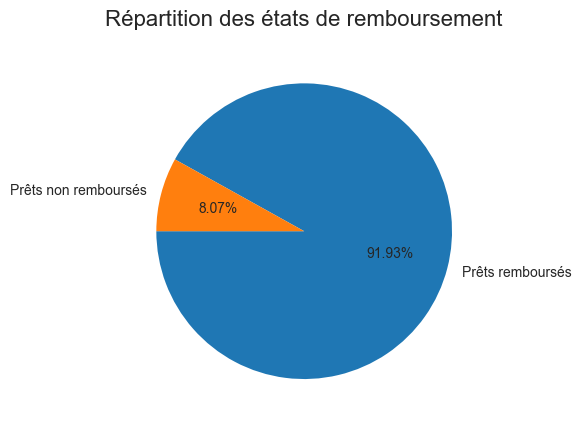

In [11]:
values = app_train['TARGET'].value_counts()
plt.pie(values, labels=['Prêts remboursés', 'Prêts non remboursés'], autopct='%1.2f%%', startangle=180)
plt.ylabel('')
plt.title('Répartition des états de remboursement', fontsize=16, pad=15)
plt.show()

La feature cible présente une __distribution fortement déséquilibrée__.  
Ce déséquilibre devra être traité afin d'éviter :  
* un biais de prédiction : les modèles ont tendance à favoriser la classe majoritaire, ce qui peut conduire à de muvaises performances sur la classe minoritaire
* des métriques de performances trompeuses : un modèle qui conduirait à accorder tous les prêts aurait une accuray de 92 %

## 2.2. Valeurs manquantes

In [12]:
def get_dataframe_infos(df):
    """Examine le dataframe (ou la series) 'df' fourni en paramètre et renvoit un dataframe 'df_infos' composé des variables :
       - 'Colonne' : nom des variables de df
       - 'Type' : type de la colonne
       - 'Valeurs uniques' : nombre de valeurs unique de la colonne
       - 'Valeurs manquantes' : nombre de valeurs manquantes de la colonne
       - '% valeurs manquantes' : pourcentage de valeurs manquantes de la colonne
       - 'Doublons' : nombre de valeurs non uniques (doublons) de la colonne
    """
    if isinstance(df, pd.Series):
        df = df.to_frame()
    number_of_rows = df.shape[0]
    col_names = df.columns
    col_types = df.dtypes
    unique_values = df.nunique()
    missing_values = df.isnull().sum()
    non_missing_values = number_of_rows - missing_values
    duplicate_values = non_missing_values - unique_values

    df_infos = pd.DataFrame({
        'Colonne': col_names,
        'Type': col_types,
        'Valeurs uniques': unique_values,
        'Doublons': duplicate_values,
        'Valeurs manquantes': missing_values,
        '% valeurs manquantes': round((missing_values / number_of_rows) * 100, 1).astype(str) + " %"
    }).reset_index(drop=True)

    return df_infos

In [13]:
pd.set_option('display.max_rows', 122)
app_train_infos = get_dataframe_infos(app_train)

In [14]:
mask = app_train_infos['Valeurs manquantes'] > 0
display(app_train_infos.loc[mask, ['Colonne', 'Valeurs manquantes', '% valeurs manquantes']].sort_values('% valeurs manquantes', ascending=False).head(20))
print(f"{len(app_train_infos.loc[mask])} colonnes ont des valeurs manquantes.")

,Colonne,Valeurs manquantes,% valeurs manquantes
76,COMMONAREA_MEDI,214865,69.9 %
48,COMMONAREA_AVG,214865,69.9 %
62,COMMONAREA_MODE,214865,69.9 %
84,NONLIVINGAPARTMENTS_MEDI,213514,69.4 %
70,NONLIVINGAPARTMENTS_MODE,213514,69.4 %
56,NONLIVINGAPARTMENTS_AVG,213514,69.4 %
68,LIVINGAPARTMENTS_MODE,210199,68.4 %
82,LIVINGAPARTMENTS_MEDI,210199,68.4 %
54,LIVINGAPARTMENTS_AVG,210199,68.4 %
86,FONDKAPREMONT_MODE,210295,68.4 %


67 colonnes ont des valeurs manquantes.


Certains modèles sont capables de travailler directement avec des données manquantes ou disposent de mécanismes intégrés pour les gérer.   
Pour les autres, il conviendra d'utiliser des techniques d'imputation avant de les utiliser.  

## 2.3. Types de données

In [15]:
# Nombres de features pour chaque type
display(app_train.dtypes.value_counts())

float64    65
int64      41
object     16
Name: count, dtype: int64

In [16]:
# Nombres de modalités des features catégorielles
display(app_train_infos.loc[app_train_infos['Type'] == 'object', ['Colonne', 'Type', 'Valeurs uniques']])

,Colonne,Type,Valeurs uniques
2,NAME_CONTRACT_TYPE,object,2
3,CODE_GENDER,object,3
4,FLAG_OWN_CAR,object,2
5,FLAG_OWN_REALTY,object,2
11,NAME_TYPE_SUITE,object,7
12,NAME_INCOME_TYPE,object,8
13,NAME_EDUCATION_TYPE,object,5
14,NAME_FAMILY_STATUS,object,6
15,NAME_HOUSING_TYPE,object,6
28,OCCUPATION_TYPE,object,18


La majorité des features catégorielles ont un faible nombre de modalités.  
Étonnament, la feature `CODE_GENDER` possède 3 modalités.

In [17]:
# Nombres de valeurs uniques de la feature `CODE_GENDER`
app_train['CODE_GENDER'].value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

Seuls 4 clients ont un `CODE_GENDER` manquant, ils peuvent être supprimés

In [18]:
# Suppression
app_train = app_train.loc[app_train['CODE_GENDER'] != 'XNA']

In [19]:
# Vérification sur le jeu de données de test
app_test['CODE_GENDER'].value_counts()

CODE_GENDER
F    32678
M    16066
Name: count, dtype: int64

Pour les features avec 2 modalités le choix se porte sur un LabelEncoding, celles avec plus de 2 modalités seront traitées avec un encodage OneHot

In [20]:
# Creation d'un objet LabelEncoder
label_encoder = LabelEncoder()
le_count = 0

# Boucle sur toutes les features
for col in app_train:
    if app_train[col].dtype == 'object':
        # Traitement du cas 'nombre de modalités <= 2'
        if len(list(app_train[col].unique())) <= 2:
            # Fit sur l'ensemble d'entraînement
            label_encoder.fit(app_train[col])
            # Transform sur les données d'apprentissage et de test
            app_train[col] = label_encoder.transform(app_train[col])
            app_test[col] = label_encoder.transform(app_test[col])
            
            # Nombre de features traitées
            le_count += 1
            
print(f'LabelEncoding effectué sur {le_count} features.')

LabelEncoding effectué sur 4 features.


In [21]:
# Traitement des features ayant plus de 2 modalités (toutes celles restant de type 'object')
# Encodage OneHot avec pandas get_dummies
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Dimensions app_train  : ', app_train.shape)
print('Dimensions test_train : ', app_test.shape)

Dimensions app_train  :  (307507, 241)
Dimensions test_train :  (48744, 238)


Les données d'entraînement ont plus de features que celles de test (il devrait n'y en avoir qu'une, la feature `TARGET`). Cela est dû au fait que l'encodage OneHot crée une feature par modalité (avec 0 ou 1 en fonction de la valeur d'origine de la feature encodée).  
Il y a donc certaines modalités qui ne sont pas rencontrées dans l'ensemble de test alors qu'elles étaient présentes dans les donnée d'entraînement.  
Il est nécessaire de supprimer les features en trop dans les données d'entrainement afin d'avoir 2 jeux de données parfaitement alignés.

In [22]:
# Sauvegarde de la feature 'TARGET'
train_labels = app_train['TARGET']

# Alignement des 2 jeux de données en ne conservant que les features communes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Rajout de la colonne 'TARGET' dans le jeu d'entraînement
app_train['TARGET'] = train_labels

print('Dimensions app_train  : ', app_train.shape)
print('Dimensions test_train : ', app_test.shape)

Dimensions app_train  :  (307507, 239)
Dimensions test_train :  (48744, 238)


## 2.4 Valeurs aberrantes

La feature `DAYS_BIRTH` correspond au nombre de jours passés depuis la date de naissance du client et stockée sous la forme d'un nombre négatif.

In [23]:
# Feature DAYS_BIRTH
display((app_train['DAYS_BIRTH'] / -365).describe())

count    307507.000000
mean         43.937061
std          11.956116
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Une fois affichée en années, il n'y a pas de valeurs aberrantes

In [24]:
# Feature DAYS_EMPLOYED (ancienneté)
display((app_train['DAYS_EMPLOYED'] / -365).describe())

count    307507.000000
mean       -174.838162
std         387.058829
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

La valeur maximale correspond à un peu plus de 1 000 ans d'ancienneté... négative

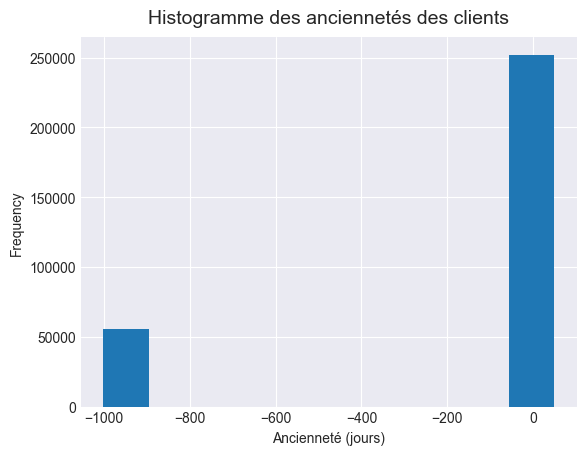

In [25]:
(app_train['DAYS_EMPLOYED'] / -365).plot.hist()
plt.title('Histogramme des anciennetés des clients', fontsize=14, pad=10)
plt.xlabel('Ancienneté (jours)')
plt.show()

In [26]:
# Nombre de prêts dont les clients ont une ancienneté aberrante
anom_value = app_train['DAYS_EMPLOYED'].max()
anomalies = app_train['DAYS_EMPLOYED'] == anom_value
len(app_train.loc[anomalies])

55374

Le nombre de prêts concernés est important, et il serait dommage de les supprimer de l'étude.  
Une solution sans risque de biaiser les modèle est de leur attribuer la valeur NaN et de créer une feature binarisée `DAYS_EMPLOYED_ANOM` indiquant si l'ancienneté du client est en anomalie ou non.

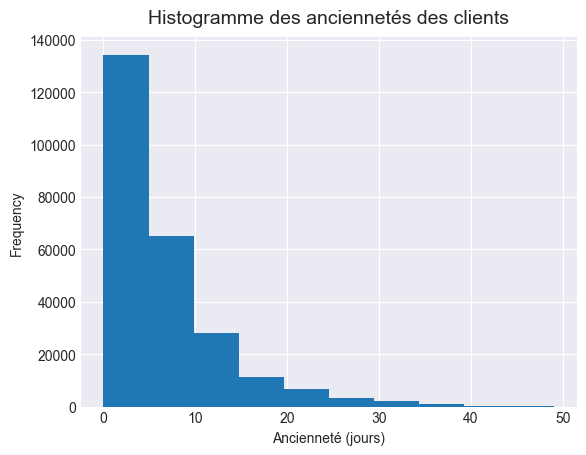

In [27]:
# Création de la feature 'DAYS_EMPLOYED_ANOM'
app_train['DAYS_EMPLOYED_ANOM'] = (app_train['DAYS_EMPLOYED'] == anom_value)

# Remplacement des modalités en anomalie par NaN
app_train['DAYS_EMPLOYED'] = app_train['DAYS_EMPLOYED'].replace({anom_value: np.nan})

(app_train['DAYS_EMPLOYED'] / -365).plot.hist()
plt.title('Histogramme des anciennetés des clients', fontsize=14, pad=10)
plt.xlabel('Ancienneté (jours)')
plt.show()

## 2.5. Corrélations

In [28]:
if FAST_MODE and os.path.exists('correlations.csv'):
    print('FAST_MODE actif : Chargement du fichier correlations.csv... ', end='')
    correlations = pd.read_csv('correlations.csv')
    print('Ok')
else:
    # Corrélations avec la feature cible
    correlations = app_train.corr()['TARGET'].sort_values()
    correlations.to_csv('correlations.csv')

In [29]:
# Affichage des corrélations les plus élevées
print('Plus fortes corrélations positives :\n', correlations.tail(15))
print('\nPlus fortes corrélations negatives :\n', correlations.head(15))

Plus fortes corrélations positives :
 OCCUPATION_TYPE_Laborers                             0.043017
FLAG_DOCUMENT_3                                      0.044341
REG_CITY_NOT_LIVE_CITY                               0.044394
FLAG_EMP_PHONE                                       0.045984
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049822
REG_CITY_NOT_WORK_CITY                               0.050992
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER                                          0.054710
DAYS_LAST_PHONE_CHANGE                               0.055219
NAME_INCOME_TYPE_Working                             0.057483
REGION_RATING_CLIENT                                 0.058901
REGION_RATING_CLIENT_W_CITY                          0.060895
DAYS_EMPLOYED                                        0.074957
DAYS_BIRTH                                           0.078242
TARGET                                               1.000000
Name: TARGET, dtype: float64

Pl

Les corrélations les plus fortes avec la feature `TARGET` sont observées avec la feature `DAYS_BIRTH` (âge des clients - corrélation positive) et les features `EXT_SOURCE_3`, `EXT_SOURCE_2` et `EXT_SOURCE_1` (scores normalisés issus de données externes - coorélations négatives).  
En réalité la corrélation entre `TARGET` et `DAYS_BIRTH` est une corrélation négative puisque les modalités de `DAYS_BIRTH` sont des nombres de jours nétagtifs, c'est-à-dire que plus un client est âgé moins il y a de chance qu'il soit en défaut de remboursement d'un prêt.

## 2.6. Effet de l'âge sur le remboursement

In [30]:
# Correlation entre le nombre de jours (positif) depuis la naissance d'un client et la feature 'TARGET'
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.078242160036194

Histogramme des âges en années

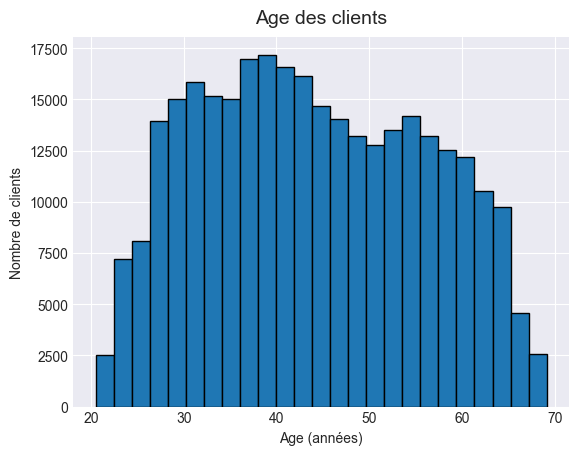

In [31]:
# Distribution des âges en années
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor='k', bins=25)
plt.title('Age des clients', fontsize=14, pad=10)
plt.xlabel('Age (années)')
plt.ylabel('Nombre de clients')
plt.show()

Distibution des âges selon la feature cible

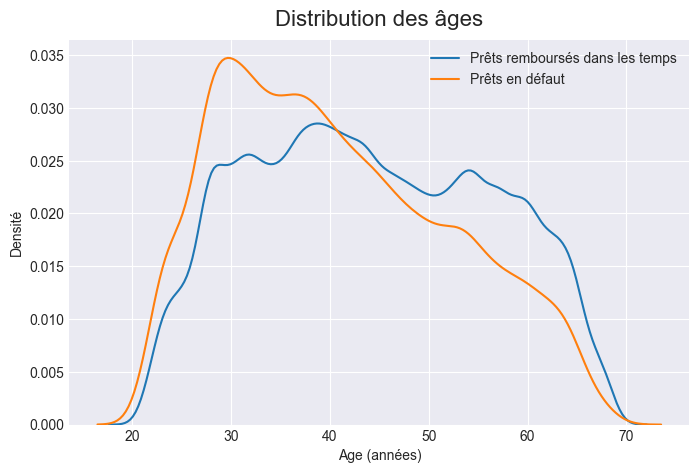

In [32]:
plt.figure(figsize = (8, 5))

# KDE plot des prêts remboursés dans les temps
sns.kdeplot(app_train.loc[app_train['TARGET']==0, 'DAYS_BIRTH'] / 365, label='Prêts remboursés dans les temps')

# KDE plot des prêts non rembousés dans les temps
sns.kdeplot(app_train.loc[app_train['TARGET']==1, 'DAYS_BIRTH'] / 365, label='Prêts en défaut')

# Légendes
plt.xlabel('Age (années)')
plt.ylabel('Densité')
plt.title('Distribution des âges', fontsize=16, pad=10)
plt.legend()
plt.show()

Même si la corrélation est faible (-0.07), les distributions sont différentes selon la feature cible, et la tendance semble être que plus les clients sont jeunes plus ils ont des difficultés à rembourser les prêts.

Un graphique du ratio de prêts en défaut de remboursement (moyenne de `TARGET`) par groupe d'âge peut aider à confirmer cette tendance.

In [33]:
# Création d'un DataFrame avec l'âge en années
age_data = app_train[['TARGET', 'DAYS_BIRTH']].copy()
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Création et affectation des classes d'âge
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins=np.linspace(20, 70, num=11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [34]:
# Calcul des ratios par classes d'âges
age_groups = age_data.groupby('YEARS_BINNED', observed=True).mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111442,10155.219690,27.822520
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089416,13707.908041,37.555912
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055316,20984.285455,57.491193
"(60.0, 65.0]",0.052737,22780.547460,62.412459


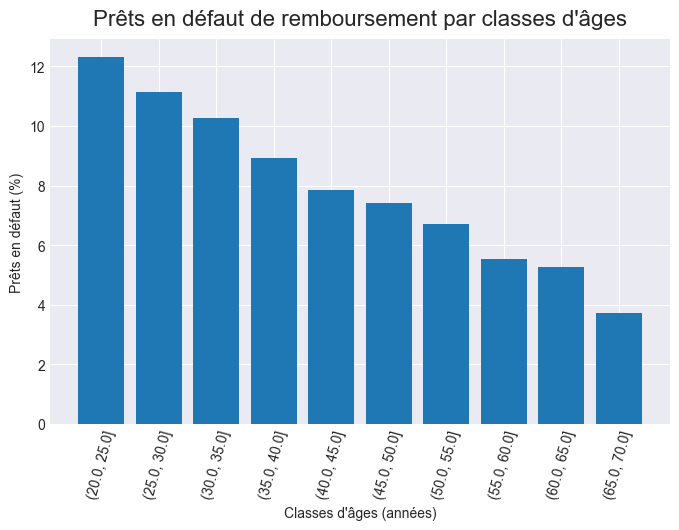

In [35]:
plt.figure(figsize = (8, 5))

# Barplot des ratios par classes d'âges
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Légendes
plt.xticks(rotation = 75)
plt.xlabel('Classes d\'âges (années)')
plt.ylabel('Prêts en défaut (%)')
plt.title('Prêts en défaut de remboursement par classes d\'âges', fontsize=16, pad=10)
plt.show()

La tendance est nette, les clients les plus jeunes sont plus nombreux à se trouver en défaut de remboursement de leurs prêts.

## 2.7. Sources externes

D'après la documentation, les 3 features `EXT_SOURCE_1`, `EXT_SOURCE_2`, et `EXT_SOURCE_3`, représentent des scores normalisés issus de sources externes. On peut supposer qu'il s'agit de compilations d'éléments externes qualifiant la capacité des clients à rembourser leurs crédits. Ces 3 features sont les plus fortement corrélées (négativement) avec la feature cible.

Matrice de corrélation réduites aux plus fortes corrélations

In [36]:
# Corrélations aux plus élevées
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
display(ext_data_corrs)

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160471,-0.178926,-0.078242
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186845,0.600621
EXT_SOURCE_2,-0.160471,0.213982,1.000000,0.109182,0.092009
EXT_SOURCE_3,-0.178926,0.186845,0.109182,1.000000,0.205465
DAYS_BIRTH,-0.078242,0.600621,0.092009,0.205465,1.000000


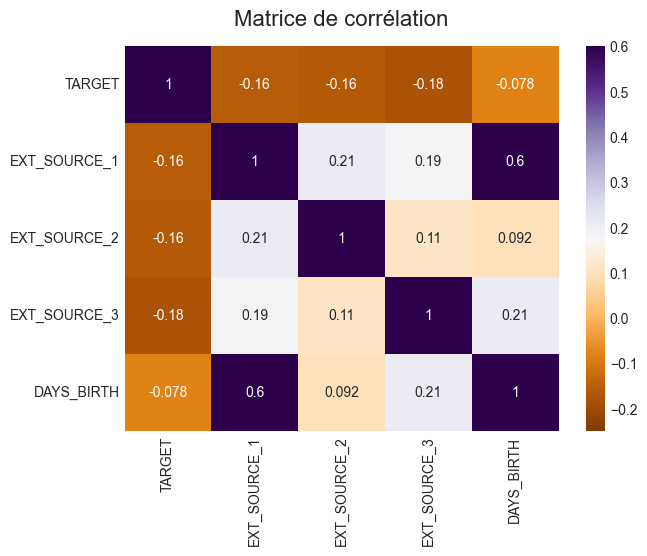

In [37]:
# Affichage de la matrice (heatmap)
plt.figure(figsize = (7, 5))
sns.heatmap(ext_data_corrs, cmap='PuOr', vmin=-0.25, annot=True, vmax=0.6)
plt.title('Matrice de corrélation', fontsize=16, pad=15)
plt.show()

A noter une corrélation forte (0.6) entre l'âge des clients et leur score `EXT_SOURCE_1` : plus les clients sont âgés, meilleurs sont leurs scores.  
Cette corrélation se vérifie dans une moindre mesure avec les scores `EXT_SOURCE_2` et `EXT_SOURCE_3`

Distributions des scores `EXT_SOURCE` selon la feature cible

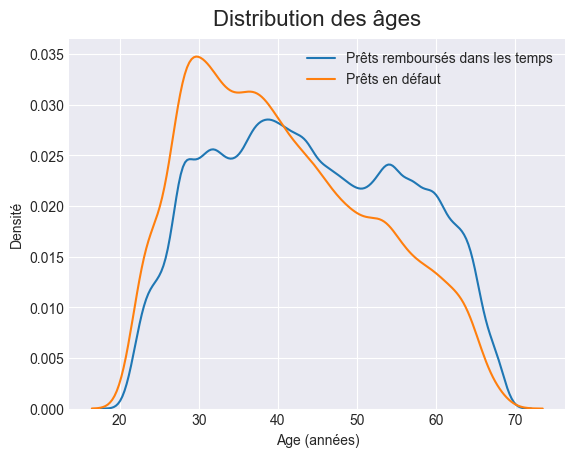

In [38]:
# KDE plot des prêts remboursés dans les temps
sns.kdeplot(app_train.loc[app_train['TARGET']==0, 'DAYS_BIRTH'] / 365, label='Prêts remboursés dans les temps')

# KDE plot des prêts non rembousés dans les temps
sns.kdeplot(app_train.loc[app_train['TARGET']==1, 'DAYS_BIRTH'] / 365, label='Prêts en défaut')

# Labeling of plot
plt.xlabel('Age (années)')
plt.ylabel('Densité')
plt.title('Distribution des âges', fontsize=16, pad=10)
plt.legend()
plt.show()

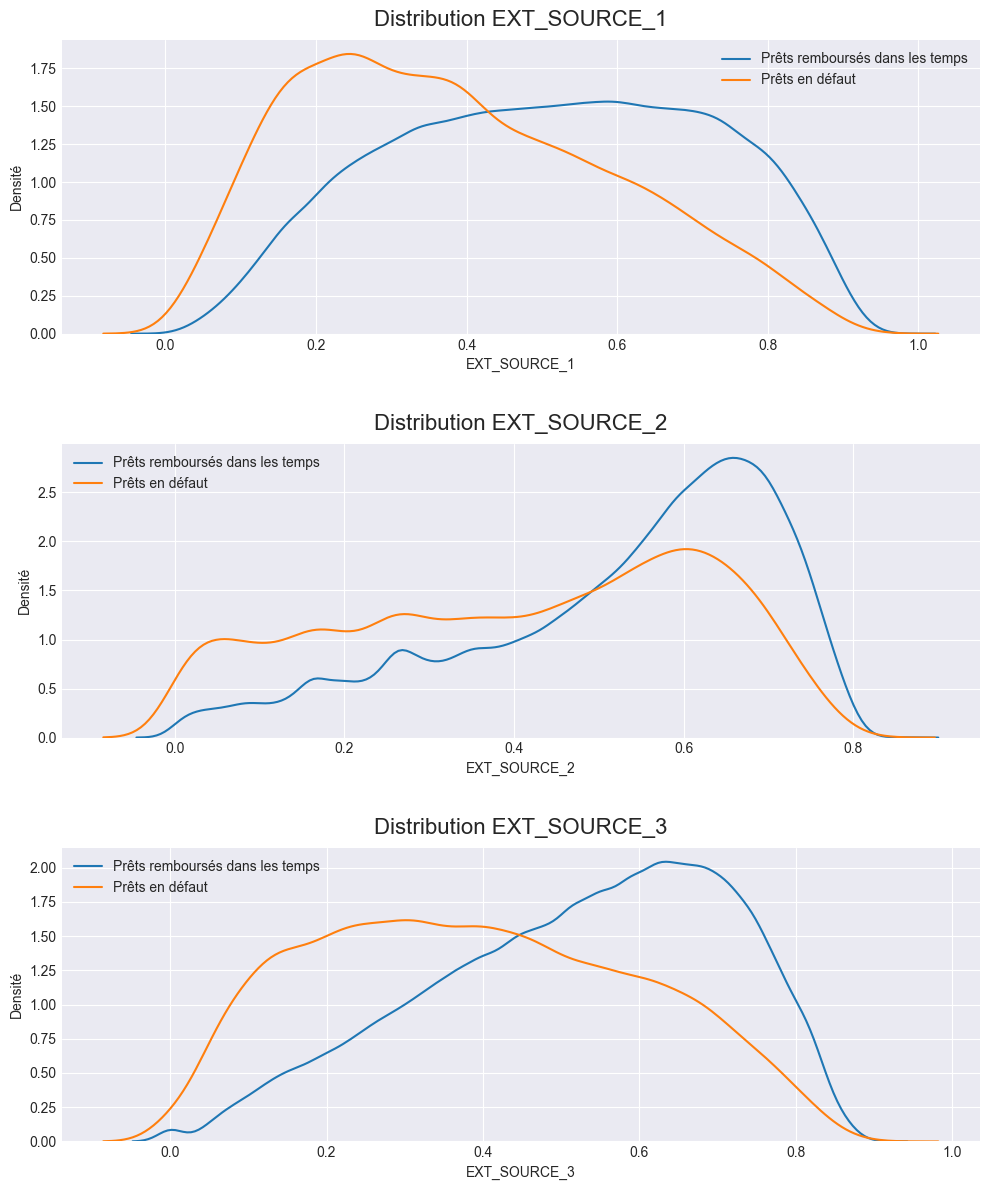

In [39]:
plt.figure(figsize = (10, 12))

# Boucles sur les features 'EXT_SOURCE'
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # Création d'un subplot
    plt.subplot(3, 1, i + 1)
    # KDE plot des prêts remboursés dans les temps
    sns.kdeplot(app_train.loc[app_train['TARGET']==0, source], label='Prêts remboursés dans les temps')
    # KDE plot des prêts non rembousés dans les temps
    sns.kdeplot(app_train.loc[app_train['TARGET']==1, source], label='Prêts en défaut')
    
    # Légendes
    plt.title(f'Distribution {source}', fontsize=16, pad=10)
    plt.xlabel(source)
    plt.ylabel('Densité')
    plt.legend()
    
plt.tight_layout(h_pad=3)
plt.show()

Quel que soit le score externe, le nombre de clients en défaut de remboursement est proportionnellement plus important lorsque le score est faible.  
Les courbes se croisent, indiquant un nombre de clients ayant des prêts remboursés dans les temps proportionnellement plus élevé lorsque le score est élevé.

In [40]:
# Libération de la mémoire
del app_train, app_test, app_train_infos, correlations, ext_data, ext_data_corrs
gc.collect()

24385

# 3. Feature Engineering

L'objectif est la préparation des données pour alimenter les modèles de classification qui seront testés.  
Les étapes de constitution du jeu de données et de création de nouvelles features sont importées du kernel Kaggle d'Aguiar : [LightGBM with Simple Features](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script)  

L'approche repose sur les étapes suivantes :  
* Concaténation des ensembles d'entrainement et de test dans un DataFrame (`df`), prétraitement et création de nouvelles features
* Jointure, prétraitement et création de nouvelles features à partir des fichiers `bureau.csv` et `bureau_balance.csv`, puis jointure avec `df`
* Prétraitement et création de nouvelles features à partir du fichier `previous_applications.csv`, puis jointure avec `df`
* Création de nouvelles features à partir du fichier `POS_CASH_balance.csv`, puis jointure avec `df`  
* Création de nouvelles features à partir du fichier `installments_payments.csv`, puis jointure avec `df`
* Création de nouvelles features à partir du fichier `credit_card_balance.csv`, puis jointure avec `df`

La reconstitution des jeux de données 'train' et 'test'se fera simplement par filtre sur la feature `TARGET`

## 3.1. Fonctions utilitaires

Durée d'exécution

In [41]:
time_suffixes = ['sec', 'min', 'h']
# Le décorateur @contextmanage permet l'utilisation du bloc 'with'
# 'yield' marque la séparation entre le code exécuté avant le bloc 'with' et après
@contextmanager
def timer(title):
    duration_str = ''
    start_time = time.perf_counter()
    yield
    duration = int(f"{(time.perf_counter() - start_time):.0f}")
    m, s = divmod(duration, 60)
    h, m = divmod(m, 60)
    if h > 0:
        duration_str = f'{h} h '
    if m > 0:
        duration_str += f'{m} min '
    if (s > 0) or (len(duration_str) == 0):
        duration_str += f'{s} secs'
    duration_str.strip()
    print(f"{title} : effectué en {duration_str}.")

Fonction d'encodage OneHot

In [42]:
# Foncation d'encodage OneHot des variables catégorielles
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category, dtype=np.int64)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

## 3.2. Fonctions de prétraitement

### 3.2.1. application_train.csv et application_test.csv  
* Concaténation des fichiers  
* Suppression des prêts dont les clients n'ont pas de `CODE_GENDER`  
* Encodage des features catégorielles  
* Remplacement des modalités en anomalie de `DAYS_EMPLOYED` par NaN
* Création de nouvelles features (ratios)

In [43]:
# Prétraitement application_train.csv et application_test.csv
def application_train_test(num_rows=None, nan_as_category=False):
    # Chargement des fichiers
    df = pd.read_csv('./input/application_train.csv', nrows=num_rows)
    test_df = pd.read_csv('./input/application_test.csv', nrows=num_rows)
    print(f"Données d'entraînement : {len(df)}, données des test : {len(test_df)}")
    # Concaténation des DataFrames
    df = pd.concat([df, test_df]).reset_index()
    
    # Suppression des lignes avec 'CODE_GENDER' manquant
    df = df[df['CODE_GENDER'] != 'XNA']

    # Binary encoding des features catégorielles avec 2 modalités
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # One-Hot encoding des features catégorielles avec plus de 2 modalités
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Remplacement des modalités en anomalie de DAYS_EMPLOYED par NaN
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243, np.nan) #, inplace= True)
    
    # Création de nouvelles features (ratios)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

### 3.2.2. bureau.csv et bureau_balance.csv  
* Encodage des features catégorielles  
* Concaténation des fichiers
* Création de nouvelles features par aggrégations (min, max, mean, sum, var, size)

In [44]:
# Prétraitement bureau.csv et bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    # Chargement des fichiers
    bureau = pd.read_csv('./input/bureau.csv', nrows=num_rows)
    bb = pd.read_csv('./input/bureau_balance.csv', nrows=num_rows)

    # Encodage des features catégorielles
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance : aggregations et jointure avec bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    # Dictionnaire des aggrégations numériques
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    
    # Dictionnaire des aggrégations catégorielles
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    # Aggrégations bureau
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Aggrégations numériques selon feature 'CREDIT_ACTIVE_Active'
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    
    # Aggrégations numériques selon feature 'CREDIT_ACTIVE_Closed'
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    
    del closed, closed_agg, bureau
    gc.collect()
    
    return bureau_agg

### 3.2.3. previous_applications.csv  
* Encodage des features catégorielles  
* Traitement des valeurs aberrantes
* Création d'une nouvelle feature par calcul (ratio)
* Création de nouvelles features par aggrégations (min, max, mean, sum, var)

In [45]:
# Prétraitement previous_applications.csv
def previous_applications(num_rows=None, nan_as_category=True):
    # Chargement du fichier
    prev = pd.read_csv('./input/previous_application.csv', nrows=num_rows)

    # Encodage des features catégorielles
    prev, cat_cols = one_hot_encoder(prev, nan_as_category)
    
    # Remplacement des nombres de jours aberrants par NaN
    prev['DAYS_FIRST_DRAWING'] = prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan)
    prev['DAYS_FIRST_DUE'] = prev['DAYS_FIRST_DUE'].replace(365243, np.nan)
    prev['DAYS_LAST_DUE_1ST_VERSION'] = prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan)
    prev['DAYS_LAST_DUE'] = prev['DAYS_LAST_DUE'].replace(365243, np.nan)
    prev['DAYS_TERMINATION'] = prev['DAYS_TERMINATION'].replace(365243, np.nan)
    
    # Ajout feature 'APP_CREDIT_PERC'
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
    # Dictonnaire aggrégations numériques
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    
    # Dictionnaire aggrégations catégorielles
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    # Aggrégations previous_applications
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Aggrégations numériques selon feature 'NAME_CONTRACT_STATUS_Approved'
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Aggrégations numériques selon feature 'NAME_CONTRACT_STATUS_Refused'
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

### 3.2.4. POS_CASH_balance.csv  
* Encodage des features catégorielles  
* Création de nouvelles features par aggrégations (max, mean, size)

In [46]:
# Prétraitement POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category=True):
    # Chargement du fichier
    pos = pd.read_csv('./input/POS_CASH_balance.csv', nrows=num_rows)

    # Encodegae des features catégorielle
    pos, cat_cols = one_hot_encoder(pos, nan_as_category)
    
    # Dictionnaires d'aggrégations
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    # Aggrégations
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Création feature 'POS_COUNT'
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    
    del pos
    gc.collect()
    return pos_agg


### 3.2.5. installments_payments.csv  
* Encodage des features catégorielles  
* Création de nouvelles features par calcul (ratio et différences)
* Création de nouvelles features par aggrégations (max, mean, sum, var, size)

In [47]:
# Preprocess installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=True):
    # Chargement du fichier
    ins = pd.read_csv('./input/installments_payments.csv', nrows=num_rows)

    # Encodage des features catégorielles
    ins, cat_cols = one_hot_encoder(ins, nan_as_category)
    
    # Création de nouvelles features
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # DPD : Days past due, DBD days before due (valeurs positives uniquement)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Dictionnaire aggrégations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    # Aggrégations
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    # Création feature 'INSTALL_COUNT'
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    del ins
    gc.collect()
    return ins_agg

### 3.2.6. credit_card_balance.csv  
* Encodage des features catégorielles  
* Création de nouvelles features par aggrégations (min, max, mean, sum, var, size)

In [48]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    # Chargement du fichier
    cc = pd.read_csv('./input/credit_card_balance.csv', nrows=num_rows)

    # Encodage des features catégorielles
    cc, cat_cols = one_hot_encoder(cc, nan_as_category)
    
    # Aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Création feature 'CC_COUNT' : Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    del cc
    gc.collect()
    return cc_agg

## 3.3. Création des jeux de données  
* Application des prétraitements et du feature ingineering
* Réduction de dimension
* Version avec valeurs manquantes
* Version avec imputations

### 3.3.1. Prétraitement et feature ingineering

In [49]:
def preprocess_feature_ingineering(debug=False):
    num_rows = 10000 if debug else None

    # application_train.csv et application_test.csv
    df = application_train_test(num_rows)

    # bureau.csv et bureau_balance.csv
    bureau = bureau_and_balance(num_rows)
    print(f"Bureau : {bureau.shape} - Valeurs manquantes : {bureau.isna().sum().sum()}")
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()     

    # previous_applications.csv
    prev = previous_applications(num_rows)
    print(f"Previous applications : {prev.shape} - Valeurs manquantes : {prev.isna().sum().sum()}")
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()

    # POS_CASH_balance.csv
    pos = pos_cash(num_rows)
    print(f"Pos-cash balance : {pos.shape} - Valeurs manquantes : {pos.isna().sum().sum()}")
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
    
    # installments_payments.csv
    ins = installments_payments(num_rows)
    print(f"Installments payments : {ins.shape} - Valeurs manquantes : {ins.isna().sum().sum()}")
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
    
    # credit_card_balance.csv
    cc = credit_card_balance(num_rows)
    print(f"Credit card balance : {cc.shape} - Valeurs manquantes : {cc.isna().sum().sum()}")
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()
    
    return df

In [50]:
if FAST_MODE and os.path.exists('preprocessing.csv'):
    print('FAST_MODE actif : chargement du fichier preprocessing.csv... ', end='')    
    df_features = pd.read_csv('preprocessing.csv')
    print('Ok')
else:
    with timer("Prétraitement et feature ingineering"):
        df_features = preprocess_feature_ingineering(debug=False)
        df_features.to_csv('preprocessing.csv', index=False)
    
print(f"df_features : {df_features.shape}")

Données d'entraînement : 307511, données des test : 48744
Bureau : (305811, 116) - Valeurs manquantes : 7152780
Previous applications : (338857, 249) - Valeurs manquantes : 7608405
Pos-cash balance : (337252, 18) - Valeurs manquantes : 0
Installments payments : (339587, 26) - Valeurs manquantes : 2054
Credit card balance : (103558, 141) - Valeurs manquantes : 896550
Prétraitement et feature ingineering : effectué en 3 min 22 secs.
df_features : (356251, 798)


In [51]:
# Affichage de quelques lignes
df_features.head(3)

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


La colonne `index` peut être supprimée

In [52]:
# Suppression colonne 'index'
df_features = df_features.drop(columns=['index'])

### 3.3.2. Réduction de l'espace mémoire occupé

In [53]:
suffixes = ['o', 'Ko', 'Mo', 'Go', 'To', 'Po']
def make_readable(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = (f'{nbytes:.2f}').rstrip('0').rstrip('.')
    return f'{f} {suffixes[i]}'

In [54]:
def reduce_mememory_usage(df):
    """ 
    Réduit chaque type de données au format le plus léger possible       
    """
  
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    return df

In [55]:
memory_occupation = make_readable(df_features.memory_usage(index=True, deep=True).sum())
print(f"Occupation mémoire df_features avant optimisation : {memory_occupation}")

with timer("Réduction occupation mémoire"):
    df_features = reduce_mememory_usage(df_features)

memory_occupation = make_readable(df_features.memory_usage(index=True, deep=True).sum())
print(f"Occupation mémoire df_features après optimisation : {memory_occupation}")

Occupation mémoire df_features avant optimisation : 2.12 Go
Réduction occupation mémoire : effectué en 4 secs.
Occupation mémoire df_features après optimisation : 612.9 Mo


### 3.3.3. Réduction de dimension  
La création de features par aggrégation a pu générer des features fortement corrélées entre elles qui feraient redondondance.  
La suppression des features présentatant une corrélation de plus de 0.98 (en valeur absolue) permettra de réduire le nombre de feature sans perte d'information.

Approche :  
* Calculer la matrice de corrélations après exclusion des features `SK_ID_CURR` et `TARGET`, en prenant la valauer absolue de chaque coefficient pour ne conserver que les valeurs positives
* Remplir une matrice de même dimension avec les valeurs booléennes `True`, sauf pour la digonale et la partie basse qui vaudront `False`
* Utiliser cette matrice booléenne pour ne conserver que la partie haute de la matrice de corrélations
* Lister toutes les colonnes ayant une valeur > 0.98
* Supprimer les features listées de `df_features`

In [56]:
if FAST_MODE and os.path.exists('df_features.csv'):
    print('FAST_MODE actif : chargement du fichier df_features.csv... ', end='')    
    df_features = pd.read_csv('df_features.csv')
    print('Ok')
else:
    with timer("Suppression des features avec corrélation > 0.98"):
        # Matrice de corrélation
        corr = df_features.drop(columns=(['SK_ID_CURR', 'TARGET'])).corr().abs()
        
        # Matrice booléenne correspondant à la partie haute
        bool_matrix = np.triu(np.ones(corr.shape), k=1).astype(bool)
        
        # Partie haute de la matrice de corrélations
        upper_corr = corr.where(bool_matrix)
    
        # Suppression des features
        to_drop = [feature for feature in upper_corr.columns if any(upper_corr[feature] > 0.98)]
        df_features = df_features.drop(columns=to_drop)

        del corr
        gc.collect()
    
    with timer("Sauvegarde df_features.csv"):
        df_features.to_csv("df_features.csv", index=False)
        
    print(f"{len(to_drop)} features supprimées.")
    
print(f"df_features : {df_features.shape}")

Suppression des features avec corrélation > 0.98 : effectué en 6 min 53 secs.
Sauvegarde df_features.csv : effectué en 2 min 5 secs.
89 features supprimées.
df_features : (356251, 708)


### 3.3.4. Version avec valeurs manquantes

Recherche des valeurs infinies

In [57]:
# Recherche des valeurs 'np.inf'
numeric_features = df_features.select_dtypes(include=[np.number])
num_inf = np.isinf(numeric_features).values.sum()
print(f"Nombre de valeurs np.inf : {num_inf} ({(num_inf / df_features.size):.2%})")

Nombre de valeurs np.inf : 42 (0.00%)


Remplacement par NaN

In [58]:
# np.inf -> np.nan
df_features = df_features.replace([np.inf, -np.inf], np.nan)

Reconstitution des jeux de données

In [59]:
if FAST_MODE and os.path.exists('df_train_nan.csv') and os.path.exists('df_test_nan.csv'):
    print('FAST_MODE actif : Chargement du fichier df_train_nan.csv... ', end='')
    df_train_nan = pd.read_csv('df_train_nan.csv')
    print('Ok')
    print('FAST_MODE actif : Chargement du fichier df_test_nan.csv... ', end='')
    df_test_nan = pd.read_csv('df_test_nan.csv')
    print('Ok')
else:
    # Filtre sur colonne 'TARGET' (seul le jeu d'entraînement a cette feature de renseignée)
    target_mask = df_features['TARGET'].notna()
    
    # Reconstitution des datasets
    with timer("Reconstitutions df_train_nan et df_test_nan"):
        df_train_nan = df_features.loc[target_mask]
        df_test_nan = df_features.loc[~target_mask].drop(columns=['TARGET'])
    
    # Sauvegardes
    with timer("Sauvegarde df_train_nan.csv et df_test_nan.csv"):
        df_train_nan.to_csv("df_train_nan.csv", index=False)
        df_test_nan.to_csv("df_test_nan.csv", index=False)

Reconstitutions df_train_nan et df_test_nan : effectué en 1 secs.
Sauvegarde df_train_nan.csv et df_test_nan.csv : effectué en 1 min 39 secs.


### 3.4. Versions sans valeurs manquantes  
#### 3.4.1. Remplacement des valeurs manquantes par les médianes

In [60]:
if FAST_MODE and os.path.exists('df_train_median.csv') and os.path.exists('df_test_median.csv'):
    print('FAST_MODE actif : Chargement du fichier df_train_median.csv... ', end='')
    df_train = pd.read_csv('df_train_median.csv')
    print('Ok')
    print('FAST_MODE actif : Chargement du fichier df_test_median.csv... ', end='')
    df_test = pd.read_csv('df_test_median.csv')
    print('Ok')
else:
    with timer("Remplacement des valeurs manquantes par la médiane"):
        df_train_median = df_train_nan.copy()
        df_test_median = df_test_nan.copy()
    
        # Variables à prendre en compte
        X_train_median = df_train_median.drop(columns=['TARGET'])
        y_train_medain = df_train_median['TARGET']    
        
        # Initialisation du transformer
        imputer = SimpleImputer(strategy='mean')
        
        # Fit sur les données d'entrainement
        imputer.fit(X_train_median)
    
        # Transform sur les données d'entraînement et de test
        df_train_median[X_train_median.columns] = imputer.transform(df_train_median[X_train_median.columns])
        df_test_median[X_train_median.columns] = imputer.transform(df_test_median[X_train_median.columns])
    
    with timer("Sauvegarde df_train.csv et df_test.csv"):
        df_train_median.to_csv("df_train_median.csv", index=False)
        df_test_median.to_csv("df_test_median.csv", index=False)

Remplacement des valeurs manquantes par la médiane : effectué en 9 secs.
Sauvegarde df_train.csv et df_test.csv : effectué en 3 min 24 secs.


#### 3.4.2. Remplacement des valeurs manquantes par les moyennes 

In [61]:
if FAST_MODE and os.path.exists('df_train_mean.csv') and os.path.exists('df_test_mean.csv'):
    print('FAST_MODE actif : Chargement du fichier df_train_mean.csv... ', end='')
    df_train = pd.read_csv('df_train_mean.csv')
    print('Ok')
    print('FAST_MODE actif : Chargement du fichier df_test_mean.csv... ', end='')
    df_test = pd.read_csv('df_test.csv')
    print('Ok')
else:
    with timer("Remplacement des valeurs manquantes par la moyenne"):
        df_train_mean = df_train_nan.copy()
        df_test_mean = df_test_nan.copy()
    
        # Variables à prendre en compte
        X_train_mean = df_train_mean.drop(columns=['TARGET'])
        y_train_mean = df_train_mean['TARGET']    
        
        # Initialisation du transformer
        imputer = SimpleImputer(strategy='mean')
        
        # Fit sur les données d'entrainement
        imputer.fit(X_train_mean)
    
        # Transform sur les données d'entraînement et de test
        df_train_mean[X_train_mean.columns] = imputer.transform(df_train_mean[X_train_mean.columns])
        df_test_mean[X_train_mean.columns] = imputer.transform(df_test_mean[X_train_mean.columns])
    
    with timer("Sauvegarde df_train_mean.csv et df_test_mean.csv"):
        df_train_mean.to_csv("df_train_mean.csv", index=False)
        df_test_mean.to_csv("df_test_mean.csv", index=False)

Remplacement des valeurs manquantes par la moyenne : effectué en 8 secs.
Sauvegarde df_train_mean.csv et df_test_mean.csv : effectué en 3 min 22 secs.


We will use [`LogisticRegression`from Scikit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for our first model. The only change we will make from the default model settings is to lower the [regularization parameter](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), C, which controls the amount of overfitting (a lower value should decrease overfitting). This will get us slightly better results than the default `LogisticRegression`, but it still will set a low bar for any future models.

Here we use the familiar Scikit-Learn modeling syntax: we first create the model, then we train the model using `.fit` and then we make predictions on the testing data using `.predict_proba` (remember that we want probabilities and not a 0 or 1).

In [62]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

NameError: name 'train' is not defined

Now that the model has been trained, we can use it to make predictions. We want to predict the probabilities of not paying a loan, so we use the model `predict.proba` method. This returns an m x 2 array where m is the number of observations. The first column is the probability of the target being 0 and the second column is the probability of the target being 1 (so for a single row, the two columns must sum to 1). We want the probability the loan is not repaid, so we will select the second column.

The following code makes the predictions and selects the correct column.

In [ ]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

The predictions must be in the format shown in the `sample_submission.csv` file, where there are only two columns: `SK_ID_CURR` and `TARGET`. We will create a dataframe in this format from the test set and the predictions called `submit`. 

In [ ]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

The predictions represent a probability between 0 and 1 that the loan will not be repaid. If we were using these predictions to classify applicants, we could set a probability threshold for determining that a loan is risky. 

In [ ]:
# Save the submission to a csv file
submit.to_csv('log_reg_baseline.csv', index = False)

The submission has now been saved to the virtual environment in which our notebook is running. To access the submission, at the end of the notebook, we will hit the blue Commit & Run button at the upper right of the kernel. This runs the entire notebook and then lets us download any files that are created during the run. 

Once we run the notebook, the files created are available in the Versions tab under the Output sub-tab. From here, the submission files can be submitted to the competition or downloaded. Since there are several models in this notebook, there will be multiple output files. 

__The logistic regression baseline should score around 0.671 when submitted.__

## Improved Model: Random Forest

To try and beat the poor performance of our baseline, we can update the algorithm. Let's try using a Random Forest on the same training data to see how that affects performance. The Random Forest is a much more powerful model especially when we use hundreds of trees. We will use 100 trees in the random forest.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# Train on the training data
random_forest.fit(train, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index = False)

These predictions will also be available when we run the entire notebook. 

__This model should score around 0.678 when submitted.__

### Make Predictions using Engineered Features

The only way to see if the Polynomial Features and Domain knowledge improved the model is to train a test a model on these features! We can then compare the submission performance to that for the model without these features to gauge the effect of our feature engineering.

In [ ]:
poly_features_names = list(app_train_poly.columns)

# Impute the polynomial features
imputer = Imputer(strategy = 'median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# Train on the training data
random_forest_poly.fit(poly_features, train_labels)

# Make predictions on the test data
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_engineered.csv', index = False)

This model scored 0.678 when submitted to the competition, exactly the same as that without the engineered features. Given these results, it does not appear that our feature construction helped in this case. 

#### Testing Domain Features

Now we can test the domain features we made by hand.

In [ ]:
app_train_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(app_train_domain.columns)

# Impute the domainnomial features
imputer = Imputer(strategy = 'median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# Make predictions on the test data
predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_domain.csv', index = False)

This scores 0.679 when submitted which probably shows that the engineered features do not help in this model (however they do help in the Gradient Boosting Model at the end of the notebook).

In later notebooks, we will do more [feature engineering](https://docs.featuretools.com/index.html) by using the information from the other data sources. From experience, this will definitely help our model! 

## Model Interpretation: Feature Importances

As a simple method to see which variables are the most relevant, we can look at the feature importances of the random forest. Given the correlations we saw in the exploratory data analysis, we should expect that the most important features are the `EXT_SOURCE` and the `DAYS_BIRTH`. We may use these feature importances as a method of dimensionality reduction in future work.

In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [ ]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

As expected, the most important features are those dealing with `EXT_SOURCE` and `DAYS_BIRTH`. We see that there are only a handful of features with a significant importance to the model, which suggests we may be able to drop many of the features without a decrease in performance (and we may even see an increase in performance.) Feature importances are not the most sophisticated method to interpret a model or perform dimensionality reduction, but they let us start to understand what factors our model takes into account when it makes predictions. 

In [ ]:
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

We see that all four of our hand-engineered features made it into the top 15 most important! This should give us confidence that our domain knowledge was at least partially on track.